In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ace-dataset/ACE_dataset.csv
/kaggle/input/ace-dataset/ACE_dataset.fasta
/kaggle/input/ace-dataset/all_ACE_auto_feat.csv
/kaggle/input/ace-dataset/features/ACE_ASDC.csv
/kaggle/input/ace-dataset/features/opf_7bit_type_1_features.csv
/kaggle/input/ace-dataset/features/opf_7bit_type_2_features.csv
/kaggle/input/ace-dataset/features/esmv1_feat_ACE.csv
/kaggle/input/ace-dataset/features/ACE_embeddings_prot_t5_xl_bfd.csv
/kaggle/input/ace-dataset/features/esm2_t6_8M_feat_ACE.csv
/kaggle/input/ace-dataset/features/opf_7bit_type_3_features.csv
/kaggle/input/ace-dataset/features/opf_10bit_features.csv
/kaggle/input/ace-dataset/features/ACE_AAC.csv


In [ ]:
# # Current directory
# import os
# os.chdir('F:\Work\Experiment\pLM4ACE\model')

In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
import csv

# Helper function to standard scale data
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test
# Paths and data loading (adjust paths accordingly)
path1 = '/kaggle/input/ace-dataset/features/'
AAC = pd.read_csv(path1 + 'ACE_AAC.csv',header=None).iloc[:, 1:]
ASDC = pd.read_csv(path1 + 'ACE_ASDC.csv',header=None).iloc[:, 1:]
OPF_7bit_type_1 = pd.read_csv(path1 + 'opf_7bit_type_1_features.csv',header=None).iloc[1:, 1:]
OPF_7bit_type_2 = pd.read_csv(path1 + 'opf_7bit_type_2_features.csv',header=None).iloc[1:, 1:]
OPF_7bit_type_3 = pd.read_csv(path1 + 'opf_7bit_type_3_features.csv',header=None).iloc[1:, 1:]
OPF_10bit = pd.read_csv(path1 + 'opf_10bit_features.csv',header=None).iloc[1:, 1:]
esmv1 = pd.read_csv(path1 + 'esmv1_feat_ACE.csv',header=None).iloc[:, :]
esm2 = pd.read_csv(path1 + 'esm2_t6_8M_feat_ACE.csv',header=None).iloc[:, :]
prot_t5 = pd.read_csv(path1 + 'ACE_embeddings_prot_t5_xl_bfd.csv',header=None).iloc[1:, 1:]

# Concatenate all features into a single array
all_feat = np.column_stack((AAC, ASDC, OPF_7bit_type_1, OPF_7bit_type_2, OPF_7bit_type_3, OPF_10bit, esmv1, esm2, prot_t5))

# Standard scale the data
label1 = np.ones((394,1))
label2 = np.zeros((626,1))
y = np.concatenate((label1,label2))

X, _ = standard_scale(all_feat, all_feat)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)


### Import Data

In [2]:
import numpy as np
import pandas as pd

X = pd.read_csv(r"/kaggle/input/ace-dataset/all_ACE_auto_feat.csv", index_col=None, header=None)
# y_new = pd.read_csv("fusion_features\Data\label.csv", index_col=False, header=None)
# Standard scale the data
label1 = np.ones((394,1))
label2 = np.zeros((626,1))
y = np.concatenate((label1,label2))

print(X.shape)
print(y.shape)
print(np.count_nonzero(y==0))
print(np.count_nonzero(y==1))

X_new = np.array(X)
y_new = np.array(y)

(1020, 800)

(1020, 1)

394

626


### Test

Epoch 1/60

12/12 [==============================] - 1s 9ms/step - loss: 0.6962 - binary_accuracy: 0.4830

Epoch 2/60

12/12 [==============================] - 0s 9ms/step - loss: 0.6922 - binary_accuracy: 0.4891

Epoch 3/60

12/12 [==============================] - 0s 7ms/step - loss: 0.6883 - binary_accuracy: 0.5000

Epoch 4/60

12/12 [==============================] - 0s 8ms/step - loss: 0.6852 - binary_accuracy: 0.5007

Epoch 5/60

12/12 [==============================] - 0s 7ms/step - loss: 0.6824 - binary_accuracy: 0.5089

Epoch 6/60

12/12 [==============================] - 0s 7ms/step - loss: 0.6793 - binary_accuracy: 0.5068

Epoch 7/60

12/12 [==============================] - 0s 7ms/step - loss: 0.6770 - binary_accuracy: 0.5129

Epoch 8/60

12/12 [==============================] - 0s 8ms/step - loss: 0.6750 - binary_accuracy: 0.5102

Epoch 9/60

12/12 [==============================] - 0s 7ms/step - loss: 0.6732 - binary_accuracy: 0.5082

Epoch 10/60

12/12 [=================

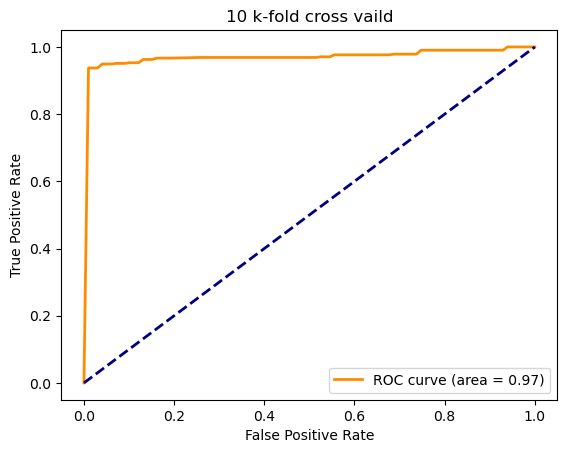

In [5]:
# K-fold cross validation
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111)

# X_train_whole = scale(X_train_whole)
[sample_num, input_dimwx]=np.shape(X_train_whole)
X = X_train

y = y_train
out_dim=2

optimizer = adam_v2.Adam(0.0002, 0.5)
n_y_value = 2

D = Sequential()
D.add(Dense(64))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(32))
D.add(Dense(2, activation='sigmoid'))
img = Input(shape=(n_y_value,))
validity = D(img)
Discriminator = Model(img,validity)
Discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['binary_accuracy'])


##### Build the generator and combine the generator and discriminator models into GAN
N_ideas = input_dimwx
G = Sequential()
G.add(Dense(64,input_dim=N_ideas))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(n_y_value, activation='tanh'))
noise = Input(shape=(N_ideas,))
G_img = G(noise)
Generator = Model(noise,G_img)

z = Input(shape=(N_ideas,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z,validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics =['binary_accuracy'])

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]

mean_recall = np.linspace(0, 1, 100)
all_precision = []
base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
# New TPR Collection
interp_tpr_collection = []


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

skf = StratifiedKFold(n_splits=10)
for train, test in skf.split(X, y):
    X_train, X_valid, y_train, y_valid = np.take(X, train.tolist(), axis=0), np.take(X, test.tolist(), axis=0), np.take(y, train.tolist(), axis=0), np.take(y, test.tolist(), axis=0)
    
    y_train = to_categorical(y_train)

    clf = GAN
    hist = clf.fit(X_train, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_valid)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_valid, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_valid, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_valid, y_score[:, 1])
    average_precision = average_precision_score(y_valid, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

# Output
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

# After all cross-validation fold, the mean TPR is calculated.
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# Save ROC curve related parameters
np.savez(r'Draw graphics\ROC curve\GAN_PCA_All_cross_vaild.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

# Save PR curve related parameters
np.savez(r'Draw graphics\PR curve\GAN_PCA_All_cross_vaild.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

# Plotting the ROC Curve
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10 k-fold cross vaild')
plt.legend(loc="lower right")
plt.show()


Epoch 1/60

13/13 [==============================] - 1s 7ms/step - loss: 0.6945 - binary_accuracy: 0.4645

Epoch 2/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6847 - binary_accuracy: 0.5349

Epoch 3/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6755 - binary_accuracy: 0.5901

Epoch 4/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6706 - binary_accuracy: 0.6170

Epoch 5/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6643 - binary_accuracy: 0.6526

Epoch 6/60

13/13 [==============================] - 0s 7ms/step - loss: 0.6606 - binary_accuracy: 0.6740

Epoch 7/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6560 - binary_accuracy: 0.7071

Epoch 8/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6528 - binary_accuracy: 0.7224

Epoch 9/60

13/13 [==============================] - 0s 8ms/step - loss: 0.6503 - binary_accuracy: 0.7359

Epoch 10/60

13/13 [=================

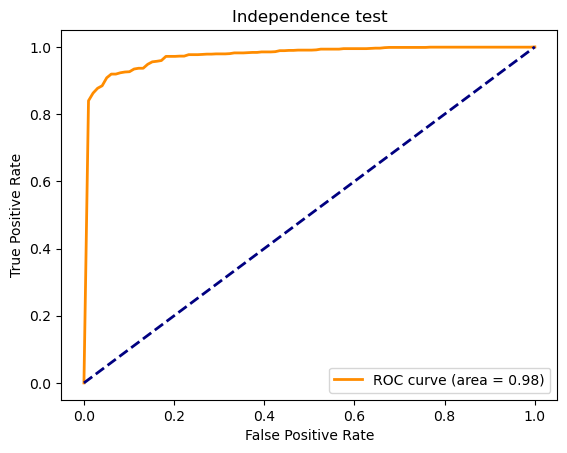

In [6]:
# Independent test set
import statistics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from keras.layers import Input, Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split


# X_new = scale(X_new)
[sample_num,input_dimwx]=np.shape(X_new)
X = X_new

y = y_new
out_dim=2

optimizer = adam_v2.Adam(0.0002, 0.5)
n_y_value = 2

D = Sequential()
D.add(Dense(64))
D.add(LeakyReLU(alpha=0.2))
D.add(Dense(32))
D.add(Dense(2, activation='sigmoid'))
img = Input(shape=(n_y_value,))
validity = D(img)
Discriminator = Model(img,validity)
Discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['binary_accuracy'])


#####Build the generator and combine the generator and discriminator into GAN
N_ideas = input_dimwx
G = Sequential()
G.add(Dense(64,input_dim=N_ideas))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(64))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(32))
G.add(LeakyReLU(alpha=0.2))
G.add(BatchNormalization(momentum=0.8))
G.add(Dense(n_y_value, activation='tanh'))
noise = Input(shape=(N_ideas,))
G_img = G(noise)
Generator = Model(noise,G_img)

z = Input(shape=(N_ideas,))
G_img = Generator(z)
Discriminator.trainable = False
validity = Discriminator(G_img)
GAN = Model(z,validity)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics =['binary_accuracy'])

BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
AP=[]
mean_recall = np.linspace(0, 1, 100)
all_precision = []

base_fpr = np.linspace(0, 1, 100)
mean_tpr = 0.0
# New TPR Collection
interp_tpr_collection = []


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


def to_categorical(y, nb_classes=None):
    y = np.array(y, dtype='int')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return Y

for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X, y, test_size=0.2, random_state=i)

    y_train = to_categorical(y_train_whole)

    clf = GAN
    hist = clf.fit(X_train_whole, y_train, batch_size=64, epochs=60)
    y_score = clf.predict(X_ind_test)
    y_class = categorical_probas_to_classes(y_score)
    TP, FP, FN, TN = confusion_matrix(y_ind_test, y_class).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))
    # ROC curve
    fpr, tpr, _ = roc_curve(y_ind_test, y_score[:, 1])
    interp_tpr = np.interp(base_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tpr_collection.append(interp_tpr)
    auc_roc = auc(fpr, tpr)
    AUC_collecton.append(auc_roc)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_ind_test, y_score[:, 1])
    average_precision = average_precision_score(y_ind_test, y_score[:, 1])
    recall = np.flipud(recall)
    precision = np.flipud(precision)

    mean_precision = np.interp(mean_recall, recall, precision)
    all_precision.append(mean_precision)
    AP.append(average_precision)

# Output
print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
print(round(statistics.mean(AUC_collecton),3),'±',round(statistics.stdev(AUC_collecton),3))
print(round(statistics.mean(AP),3),'±',round(statistics.stdev(AP),3))

# After all cross-validation fold, the mean TPR is calculated.
mean_tpr = np.mean(interp_tpr_collection, axis=0)
mean_tpr[-1] = 1.0

# Calculate the mean precision
mean_precision = np.mean(all_precision, axis=0)

# Save ROC curve related parameters
np.savez(r'Draw graphics\ROC curve\GAN_PCA_All_Indenpendence.npz', fpr=base_fpr, tpr=mean_tpr, roc_auc=AUC_collecton)

# Save PR curve related parameters
np.savez(r'Draw graphics\PR curve\GAN_PCA_All_Indenpendence.npz', recall=mean_recall, precision=mean_precision, average_precision=AP)

# Draw ROC curve
plt.figure()
lw = 2
plt.plot(base_fpr, mean_tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % np.mean(AUC_collecton))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Independence test')
plt.legend(loc="lower right")
plt.show()